### Using Tree data

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import gaussian_process
from sklearn.gaussian_process.kernels import *
import seaborn as sns

dendro = pd.read_feather("data/17766_12.feather")
dendro

,dendroNr,DOY,species,growth
0,HA_001_2012,0,Beech,0.000000
1,HA_001_2012,1,Beech,0.154100
2,HA_001_2012,2,Beech,1.460225
3,HA_001_2012,3,Beech,4.169183
4,HA_001_2012,4,Beech,3.907183
...,...,...,...,...
30805,SH_076_2013,178,Beech,3909.054208
30806,SH_076_2013,179,Beech,3908.649604
30807,SH_076_2013,180,Beech,3908.473708
30808,SH_076_2013,181,Beech,3908.421000


# Fit models

In [2]:
%%capture
# Import my GP
%run ./GP.ipynb

OptStep(params=Array([1.6296090e+03, 1.0778254e-02, 3.4586203e+00], dtype=float32), state=ScipyMinimizeInfo(fun_val=Array(34.098816, dtype=float32, weak_type=True), success=True, status=0, iter_num=40))


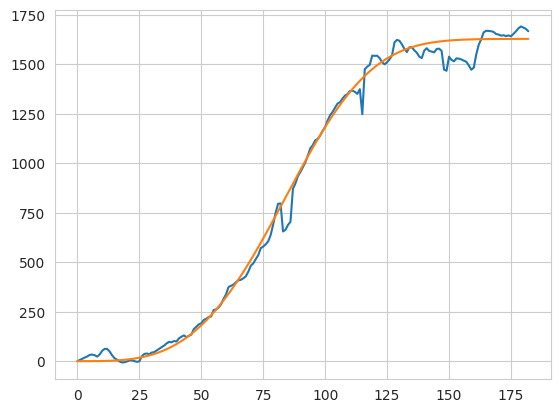

In [50]:
import jaxopt
import jax
import jax.numpy as jnp

dendro_beech = dendro[dendro.species.eq("Sycamore")]

def weibull_F(x, lambda_, k_):
    return 1 - jnp.exp(-(lambda_ * x) ** k_)

#weibull = lambda x: 1500 * weibull_F(x.ravel(), 1/95, 3.5)#2100 * weibull_F(x.ravel(), 1 / 100, 5)  # Not accurate on to give the isotropic kernel a purpose

df_ = dendro_beech.groupby("DOY", as_index = False).mean(numeric_only=True)
y_ = jnp.array(df_.growth)
x_ = jnp.array(df_.DOY)

def f_(params):
    p0, p1, p2 = params
    return jnp.mean(jax.vmap(jaxopt.loss.huber_loss)(y_, p0 * weibull_F(x_, p1, p2)))

solver = jaxopt.ScipyBoundedMinimize(fun = jax.tree_util.Partial(f_))
res = solver.run(jnp.array([1000.0, 1/5, 3]), jnp.array([(1e1, 1e-2 , 1e0), (1e5, 1e0, 1e1)]))
print(res)
plt.plot(x_, y_)
plt.plot(x_, res.params[0] * weibull_F(x_, res.params[1], res.params[2]))
plt.show()

In [34]:

p = 1

rng = np.random.default_rng()
train_idx = np.sort(rng.integers(0, len(dendro_beech), int(p * len(dendro_beech))))
print(len(train_idx))
dendro_beech_sample = dendro_beech.sort_values("DOY", ignore_index=True).loc[train_idx]

X_train = dendro_beech_sample.DOY.array.reshape(-1, 1)
y_train = dendro_beech_sample.growth.array

mean_prior = weibull(X_train)
y_train -= mean_prior

26108


In [29]:
kernel_ = ConstantKernel(309**2) * Matern(40, nu = 5/2) + WhiteKernel(27.7) * RBF(1.18**2) * DotProduct(0, "fixed")
gp_model = gaussian_process.GaussianProcessRegressor(
    kernel=kernel_,
    n_restarts_optimizer=15,
    #normalize_y=True,
    optimizer=None
)

gp_model.fit(X_train, y_train)
gp_model.kernel_, gp_model.log_marginal_likelihood_value_

(309**2 * Matern(length_scale=40, nu=2.5) + WhiteKernel(noise_level=27.7) * RBF(length_scale=1.39) * DotProduct(sigma_0=0),
 -15669.536280149892)

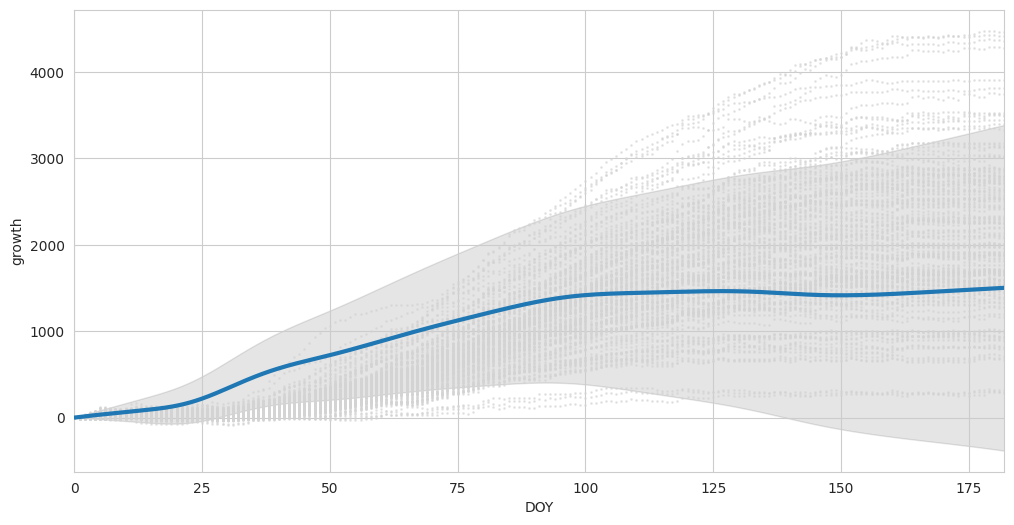

In [35]:
plt.figure(figsize=(12, 6))
X_test = np.linspace(0, dendro_beech.DOY.max(), 500).reshape(-1, 1)

#print(gp_model.kernel_)
mean_pred, std_pred = gp_model.predict(X_test, True)
y_samples = gp_model.sample_y(X_test, 1)

mean_pred += weibull(X_test)
plt.plot(
    X_test, mean_pred, lw=3, zorder=10
)
# sns.lineplot(data=dendro_beech, x="DOY", y="growth", units="dendroNr", lw=0.8, estimator=None, c="lightgray", alpha=0.3,
#              zorder=-3
#              )
plt.scatter(dendro_beech.DOY, dendro_beech.growth# - weibull(dendro_beech.DOY)
            ,c ="lightgray", alpha=0.5, s = 1)
plt.fill_between(
    X_test.ravel(),
    mean_pred - 1.96 * std_pred,
    mean_pred + 1.96 * std_pred,
    color="k", alpha=.1, zorder=0,
)
# for idx, single_prior in enumerate(y_samples.T):
#     plt.plot(
#         X_test, single_prior
#         , alpha=.4, lw=1, linestyle="dashed"
#     )
plt.xlabel("DOY")
plt.ylabel("growth")
plt.xlim(0, dendro_beech.DOY.max())
#plt.ylim(min(mean_pred)*2, max(mean_pred)*2)
plt.show()